In [ ]:
# Importar a biblioteca pandas para manipulação de dados
import pandas as pd

In [ ]:
# Carregar o conjunto de dados de interações e criar um DataFrame
data = pd.read_csv('interactions_full_df.csv')
df = pd.DataFrame(data)
# Exibir o DataFrame para inspeção
df

,user_id,content_id,game,hours,view
0,0,226,Alien Swarm,5.9,1
1,0,846,Cities Skylines,145.0,1
2,0,972,Counter-Strike,1.0,1
3,0,978,Counter-Strike Source,1.0,1
4,0,1125,Day of Defeat,1.0,1
...,...,...,...,...,...
115134,3756,108,AdVenture Capitalist,1.7,1
115135,3756,2733,Mitos.is The Game,3.2,1
115136,3756,4221,Team Fortress 2,3.2,1
115137,3756,4660,Transformice,1.3,1


In [ ]:
# Remover a coluna 'view' do DataFrame, pois não será utilizada na análise
df.drop(columns=['view'], inplace=True)

In [ ]:
# Exibir informações sobre o DataFrame, como tipos de dados e valores ausentes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115139 entries, 0 to 115138
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     115139 non-null  int64  
 1   content_id  115139 non-null  int64  
 2   game        115139 non-null  object 
 3   hours       115139 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.5+ MB


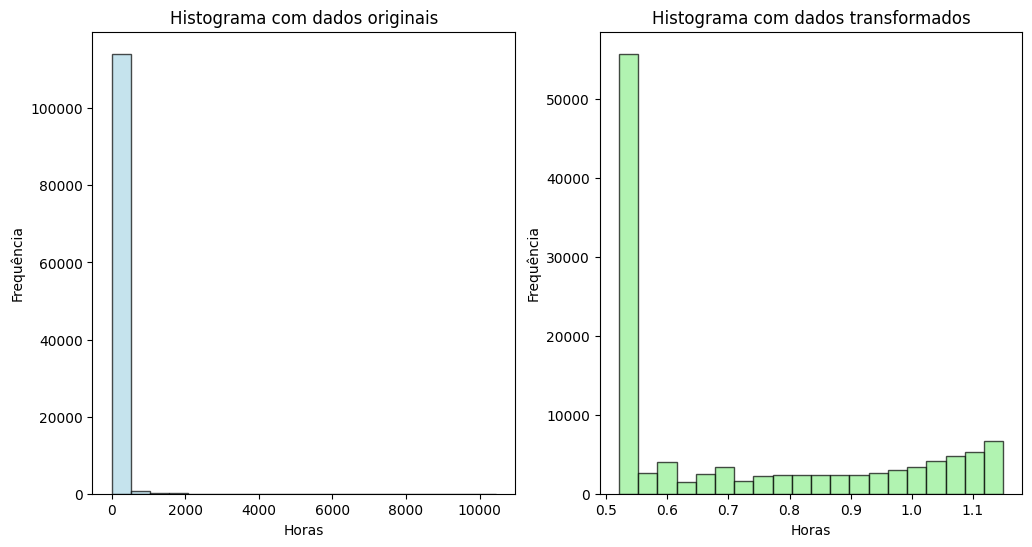

In [ ]:
# Importar bibliotecas para visualização e transformação de dados
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson

# Aplicar a transformação Yeo-Johnson na coluna 'hours'
x = df['hours']
df['hours_yj'], lmbda = yeojohnson(x)

# Visualizar os dados antes e depois da transformação
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x, bins=20, color='lightblue', edgecolor='black', alpha=0.7)
plt.title('Histograma com dados originais')
plt.xlabel('Horas')
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
plt.hist(df['hours_yj'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Histograma com dados transformados')
plt.xlabel('Horas')
plt.ylabel('Frequência')

plt.show()

In [ ]:
# Remover a coluna original 'hours', pois já foi transformada
df.drop(columns=['hours'], inplace=True)


In [ ]:
# Criar a matriz usuário-item com os dados transformados
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import csr_matrix 

user_item_matrix = df.pivot(index='user_id', columns='content_id', values='hours_yj').fillna(0)

# Escalar os dados para normalizar os valores
scaler = MaxAbsScaler()
user_item_matrix_scaled = scaler.fit_transform(user_item_matrix)

# Converter a matriz escalada para formato esparso
sparse_matrix = csr_matrix(user_item_matrix_scaled)

# Converter a matriz esparsa de volta para formato denso para uso posterior
dense_matrix = sparse_matrix.toarray()


In [ ]:
# Dividir os dados em conjuntos de treino e validação
from sklearn.model_selection import train_test_split

X_train, x_val = train_test_split(dense_matrix, test_size=0.2, random_state=42)
# Exibir as formas dos conjuntos de dados
X_train.shape, x_val.shape

((3005, 5113), (752, 5113))

In [ ]:
# Definir as dimensões de entrada e codificação para o autoencoder
input_dim = X_train.shape[1]
encoding_dim = 64

In [ ]:
# Importar bibliotecas para construção do modelo
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Construir o modelo de autoencoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

# Criar o modelo de autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Gerar embeddings de usuários a partir do autoencoder
user_embeddings = autoencoder.predict(dense_matrix)
print(f"Embeddings extraídos. Forma: {user_embeddings.shape}")

# Exibir o resumo do modelo
autoencoder.summary()

# Compilar o modelo com otimizador e métricas
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Configurar o callback de EarlyStopping para interromper o treinamento se não houver melhora
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinar o modelo de autoencoder
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_val, x_val), callbacks=[early_stopping], verbose=1)

# Avaliar o modelo no conjunto de validação
val_loss, val_mae = autoencoder.evaluate(x_val, x_val, verbose=0)
print(f"Perda de Validação (MSE) final: {val_loss:.6f}")
print(f"Erro Absoluto Médio de Validação (MAE) final: {val_mae:.6f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Embeddings extraídos. Forma: (3757, 5113)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 5113)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       327,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5113)           │       332,345 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 659,641 (2.52 MB)

 Trainable params: 659,641 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2473 - mae: 0.4965 - val_loss: 0.2343 - val_mae: 0.4831
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2219 - mae: 0.4685 - val_loss: 0.1772 - val_mae: 0.4095
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1602 - mae: 0.3843 - val_loss: 0.1131 - val_mae: 0.3084
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0981 - mae: 0.2801 - val_loss: 0.0665 - val_mae: 0.2213
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0591 - mae: 0.2044 - val_loss: 0.0392 - val_mae: 0.1590
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0331 - mae: 0.1414 - val_loss: 0.0249 - val_mae: 0.1193
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0219 - mae: 0.1077 - val_loss: 0.0175 - val_mae: 0.0942
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0158 - mae: 0.0871 - val_loss: 0.0133 - val_mae: 0.0778
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.012

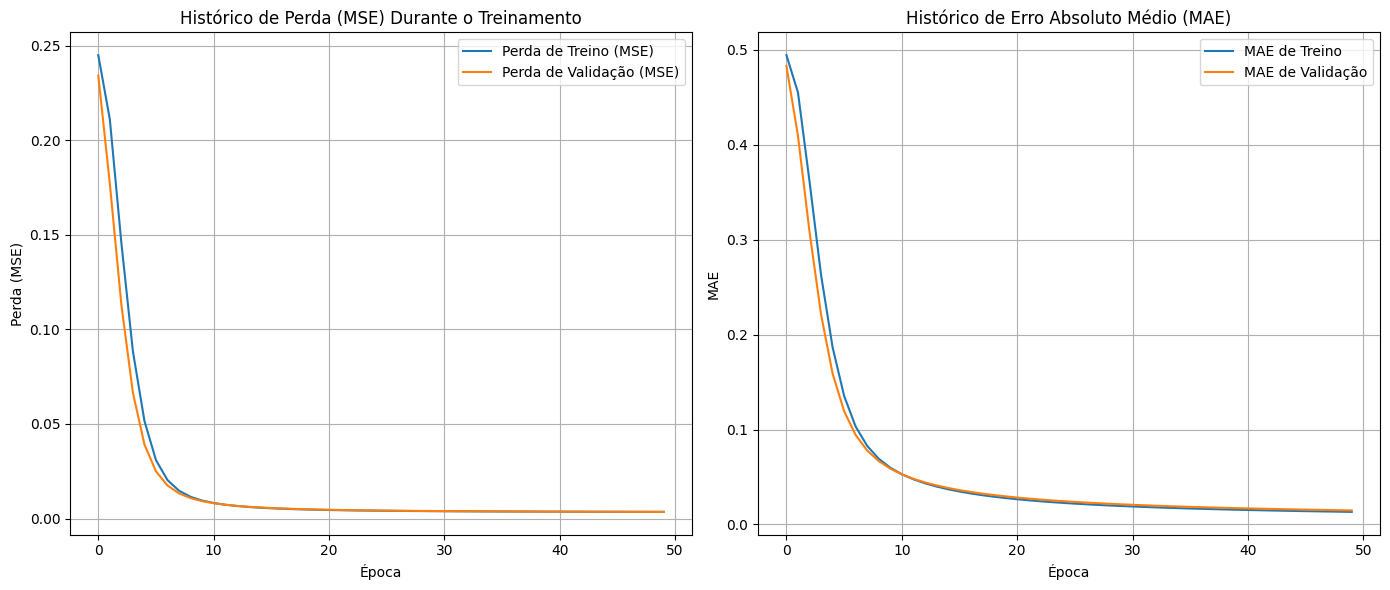

In [ ]:
# Verificar se o histórico de treinamento está disponível
if history and history.history:
    plt.figure(figsize=(14, 6))

    # Plotar a perda durante o treinamento
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Perda de Treino (MSE)')
    plt.plot(history.history['val_loss'], label='Perda de Validação (MSE)')
    plt.title('Histórico de Perda (MSE) Durante o Treinamento')
    plt.xlabel('Época')
    plt.ylabel('Perda (MSE)')
    plt.legend()
    plt.grid(True)

    # Plotar o MAE durante o treinamento
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='MAE de Treino')
    plt.plot(history.history['val_mae'], label='MAE de Validação')
    plt.title('Histórico de Erro Absoluto Médio (MAE)')
    plt.xlabel('Época')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Histórico de treinamento não disponível para plotagem.")

In [ ]:
# Calcular a similaridade entre os usuários com base nos embeddings
from sklearn.metrics.pairwise import cosine_similarity

# Calcular a similaridade entre os usuários
user_similarity = cosine_similarity(user_embeddings)
print(f"Matriz de similaridade criada. Forma: {user_similarity.shape}")

Matriz de similaridade criada. Forma: (3757, 3757)


In [ ]:
# Definir a função para gerar recomendações híbridas
import numpy as np

def hybrid_recommend(user_idx, content_ids, top_k=10, autoencoder_weight=0.6):
    """
    Gera recomendações híbridas combinando reconstrução do autoencoder e similaridade entre usuários.
    
    Args:
        user_idx: Índice do usuário na matriz
        content_ids: IDs dos conteúdos correspondentes às colunas da matriz
        top_k: Número de recomendações a serem retornadas
        autoencoder_weight: Peso atribuído às previsões do autoencoder (entre 0 e 1)
        
    Returns:
        Lista de IDs de conteúdo recomendados
    """
    # Parte 1: Recomendação baseada no autoencoder
    user_vector = dense_matrix[user_idx].reshape(1, -1)
    predicted_ratings = autoencoder.predict(user_vector, verbose=0)[0]
    
    # Parte 2: Recomendação baseada em usuários similares
    similar_users = np.argsort(user_similarity[user_idx])[::-1][1:6]  # Top 5 usuários similares
    similar_users_ratings = np.mean(dense_matrix[similar_users], axis=0)
    
    # Combinar as duas abordagens
    hybrid_scores = autoencoder_weight * predicted_ratings + (1 - autoencoder_weight) * similar_users_ratings
    
    # Excluir itens já consumidos
    consumed_items = np.where(dense_matrix[user_idx] > 0)[0]
    hybrid_scores[consumed_items] = -1
    
    # Obter os top-k itens recomendados
    top_k_items_idx = np.argsort(hybrid_scores)[::-1][:top_k]
    recommended_content_ids = [content_ids[idx] for idx in top_k_items_idx]
    
    return recommended_content_ids

In [ ]:
# Definir a função para exibir recomendações para um usuário específico
def show_recommendations(user_id, top_k=5):
    # Obter o índice do usuário na matriz
    try:
        user_idx = user_item_matrix.index.get_loc(user_id)
    except KeyError:
        print(f"Usuário {user_id} não encontrado no conjunto de dados.")
        return

    # Obter recomendações
    recommended_content_ids = hybrid_recommend(user_idx, user_item_matrix.columns.tolist(), top_k)

    # Exibir as recomendações
    print(f"\nRecomendações para o usuário {user_id}:")
    for i, content_id in enumerate(recommended_content_ids):
        game_name = content_id_to_game.get(content_id, "Nome não disponível")
        print(f"{i+1}. Jogo: {game_name} (ID: {content_id})")

In [ ]:
# Criar um dicionário para mapear content_id para o nome do jogo
content_id_to_game = df[['content_id', 'game']].drop_duplicates().set_index('content_id')['game'].to_dict()

In [ ]:
# Testar o sistema de recomendações para os primeiros 5 usuários
for user_id in user_item_matrix.index[:5]:
    show_recommendations(user_id)


Recomendações para o usuário 0:
1. Jogo: Counter-Strike Global Offensive (ID: 975)
2. Jogo: Unturned (ID: 4750)
3. Jogo: Warframe (ID: 4861)
4. Jogo: Counter-Strike Condition Zero (ID: 973)
5. Jogo: Counter-Strike Condition Zero Deleted Scenes (ID: 974)

Recomendações para o usuário 1:
1. Jogo: Team Fortress 2 (ID: 4221)
2. Jogo: Dota 2 (ID: 1328)
3. Jogo: Robocraft (ID: 3532)
4. Jogo: Heroes & Generals (ID: 2127)
5. Jogo: FlatOut 2 (ID: 1733)

Recomendações para o usuário 2:
1. Jogo: Team Fortress 2 (ID: 4221)
2. Jogo: Dota 2 (ID: 1328)
3. Jogo: Counter-Strike Global Offensive (ID: 975)
4. Jogo: Batman Arkham Asylum GOTY Edition (ID: 450)
5. Jogo: Battlefield Bad Company 2 (ID: 477)

Recomendações para o usuário 3:
1. Jogo: Counter-Strike Global Offensive (ID: 975)
2. Jogo: Team Fortress 2 (ID: 4221)
3. Jogo: Dota 2 (ID: 1328)
4. Jogo: Unturned (ID: 4750)
5. Jogo: Counter-Strike Source (ID: 978)

Recomendações para o usuário 4:
1. Jogo: Counter-Strike Global Offensive (ID: 975)
2. Jo